In [2]:
!pip freeze | grep keras
!pip freeze | grep Keras
!pip freeze | grep tensorflow
!pip freeze | grep h5py
!pip freeze | grep opencv 
!pip freeze | grep pandas

keras==2.7.0
keras-segmentation==0.3.0
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2
tensorflow==2.7.0
tensorflow-estimator==2.7.0
tensorflow-io-gcs-filesystem==0.21.0
h5py==2.10.0
opencv-python==4.5.5.62
pandas==1.3.5


In [3]:
# !pip install q tensorflow==2.1
# !pip install q keras==2.3.1
# !pip install git+https://github.com/qubvel/segmentation_models

# for str decode error ... run it and restart runtime
# !pip uninstall h5py -y
!pip install h5py==2.10.0

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
# !tensorboard --logdir logs --host 0.0.0.0
# !pip install -U tensorboard-plugin-profile

In [5]:
i = !ls Dataset/IDD/images/
l = !ls Dataset/IDD/masks/
len(i), len(l)

(5966, 5966)

In [6]:
l[-5:], i[-5:]

(['frame9980.png',
  'frame9982.png',
  'frame9991.png',
  'frame9994.png',
  'frame99992.png'],
 ['frame9980.jpg',
  'frame9982.jpg',
  'frame9991.jpg',
  'frame9994.jpg',
  'frame99992.jpg'])

In [7]:
import cv2
from glob import glob
import os
import numpy as np

# 100 = background
# 101 = road
# 102 = obstacle(person, rider, car, truck, bus, train, motorcycle, bicycle)

l = glob('Dataset/IDD/masks/*')
m = cv2.imread(l[2970],0)
m.shape
np.unique(m)


array([0, 1, 2], dtype=uint8)

In [8]:
import os
len(os.listdir('Dataset/IDD/Test/images/')), len(os.listdir('Dataset/IDD/masks/'))

(1016, 5966)

In [9]:
import numpy as np
import cv2
import os
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_dataset(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))

    train_x, test_x, train_y, test_y = train_test_split(images,masks, test_size=0.1702, 
                                                        random_state=168, shuffle=True)
    return train_x, train_y, test_x, test_y

train_x, train_y, val_x, val_y = load_dataset('Dataset/IDD')
print(len(train_x), len(train_y), len(val_x), len(val_y))

4950 4950 1016 1016


### TF data API

In [10]:
train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(val_x, val_y))

In [11]:
IMG_SIZE = 512
def parse_x_y(img_path,mask_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    mask = tf.io.read_file(mask_path)    
    mask = tf.image.decode_png(mask, channels=1)  
    return {'image': image, 'segmentation_mask': mask}

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE),method='nearest')    
#     if tf.random.uniform(()) > 0.5:
#         input_image = tf.image.flip_left_right(input_image)
#         input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    input_mask = tf.one_hot(input_mask, 3)
    input_mask = tf.reshape(input_mask, (IMG_SIZE, IMG_SIZE, 3))
    return input_image, input_mask

AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 42
BATCH_SIZE = 8
BUFFER_SIZE = 2*BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset = train_dataset.map(parse_x_y)

val_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_y))
val_dataset =val_dataset.map(parse_x_y)

dataset = {"train": train_dataset, "val": val_dataset}

dataset['train'] = dataset['train'].map(
    load_image_train,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

dataset['val'] = dataset['val'].map(
    load_image_train, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [12]:
for image,label in dataset['train'].take(1):
    print("Train image: ",image.shape)
    print("Train label: ",label.shape,"\n\tunique values", np.unique(label[0]))
    
for image,label in dataset['val'].take(1):
    print("Val image: ",image.shape)
    print("Val label: ",label.shape,"\n\tunique values", np.unique(label[0]))

Train image:  (8, 512, 512, 3)
Train label:  (8, 512, 512, 3) 
	unique values [0. 1.]
Val image:  (8, 512, 512, 3)
Val label:  (8, 512, 512, 3) 
	unique values [0. 1.]


In [13]:
import matplotlib.pyplot as plt

def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(7, 7))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


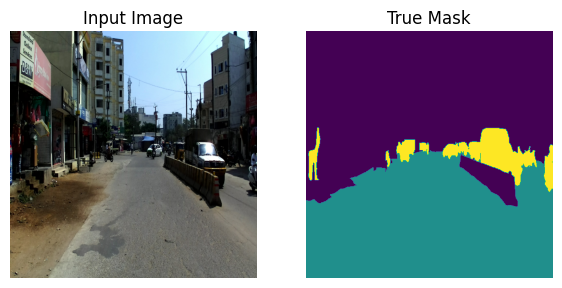

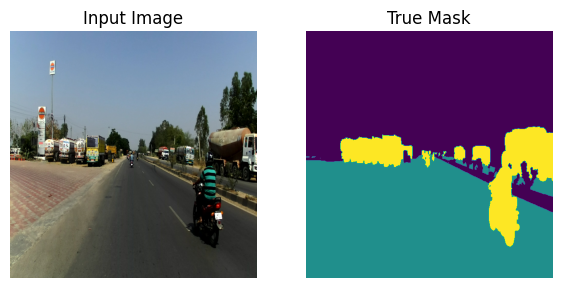

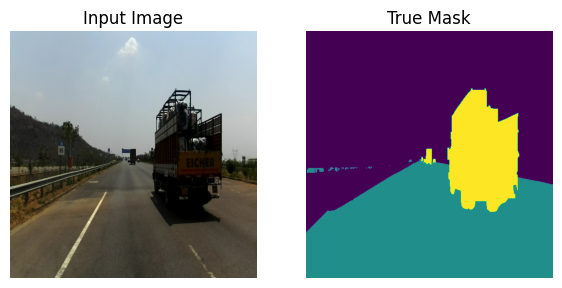

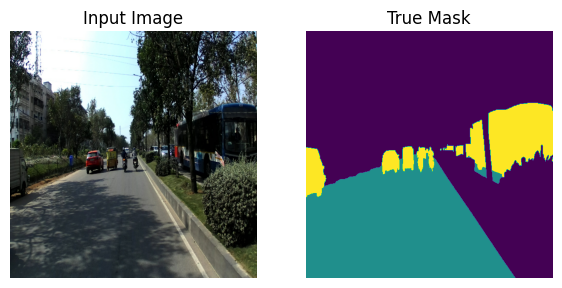

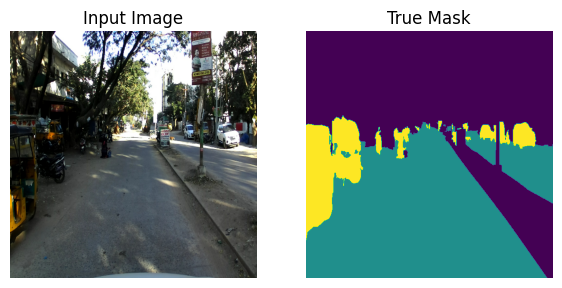

In [14]:
i=0
for image, mask in dataset['train'].take(5):
    i=i+1
#     print(i)
    sample_image, sample_mask = image, mask
    t = np.argmax(sample_mask[0],axis=-1)
    t = tf.expand_dims(t,axis=-1)
    display_sample([sample_image[0],t])

In [16]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [17]:
# !pip install keras-segmentation

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [19]:
def Unet_MobilenetV2(IMAGE_SIZE=IMG_SIZE, num_classes=3):
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(
        input_tensor=inputs,
        weights="pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_224_no_top.h5",
        include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
#     encoder.trainable = False
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(num_classes, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)
    
    model = Model(inputs, x)
    return model

In [20]:
model = Unet_MobilenetV2(IMAGE_SIZE=IMG_SIZE, num_classes=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 16  64          ['Conv1[0][0]']                  
                                )                                                             

In [21]:
# from tensorflow.keras.applications import MobileNetV2
# encoder = MobileNetV2(input_shape=[512,512,3], weights="pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_224_no_top.h5", include_top=False, alpha=0.35)
# # encoder.load_weights("pretrained_weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_224_no_top.h5")

In [22]:
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
ls = dice_loss + cce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score] 

# from tensorflow.keras.models import load_model
# model = load_model('IDD_mobilenetV2_edge/ckpt_path/350.h5',
#                    custom_objects={'dice_loss_plus_categorical_crossentropy_plus_jaccard_loss':ls,
#                                    'precision':precision, 'recall':recall, 'f1-score':f1_score, 'iou_score':iou_score})

Segmentation Models: using `tf.keras` framework.


In [23]:
import os, time, keras
%env SM_FRAMEWORK=tf.keras

import numpy as np
import tensorflow as tf
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

""" Hyperparamaters """
BATCH_SIZE = 8
epochs = 1000
base_dir = 'RESULTS/IDD_Unet_mobilenetV2_alpha0.35_custom_bs8'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(f"{base_dir}/ckpt_path")
    
csv_path = f"{base_dir}/history.csv"

""" callbacks """
root_logdir = os.path.join(os.curdir, f"{base_dir}/logs","fit","")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, histogram_freq=1,profile_batch='10,15')

checkpoint_filepath = f'{base_dir}/'+'ckpt_path/{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 25,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path),
#     EarlyStopping(monitor="val_loss", patience=10),
    tensorboard_cb
]

""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

test_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    test_steps += 1

print("train_steps", train_steps, "test_steps",test_steps)

# """ Model training """
# for layer in model.layers:
#     if layer.name == "global_average_pooling2d":
#         break
#     else:
#         layer.trainable = False

# for layer in model.layers:
#     print(layer.name,layer.trainable)

model.compile(
    loss=ls,
    optimizer= "adam",
    metrics=metrics
)
# model.summary()

env: SM_FRAMEWORK=tf.keras
train_steps 619 test_steps 127


In [ ]:
# pretrain model decoder
history = model.fit(
    dataset["train"],
    validation_data=dataset["val"],
    epochs=1000,
    initial_epoch = 0,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks
)

Epoch 1/1000


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


619/619 [==============================] - 215s 329ms/step - loss: 0.5312 - precision: 0.7785 - recall: 0.9114 - f1-score: 0.8251 - iou_score: 0.7285 - val_loss: 2.3065 - val_precision: 0.5051 - val_recall: 0.4796 - val_f1-score: 0.2979 - val_iou_score: 0.1944 - lr: 0.0010
Epoch 2/1000
619/619 [==============================] - 200s 324ms/step - loss: 0.2497 - precision: 0.9159 - recall: 0.9408 - f1-score: 0.9263 - iou_score: 0.8689 - val_loss: 1.9708 - val_precision: 0.6292 - val_recall: 0.6184 - val_f1-score: 0.4730 - val_iou_score: 0.3247 - lr: 0.0010
Epoch 3/1000
619/619 [==============================] - 201s 324ms/step - loss: 0.2137 - precision: 0.9306 - recall: 0.9478 - f1-score: 0.9381 - iou_score: 0.8879 - val_loss: 0.6347 - val_precision: 0.7765 - val_recall: 0.8722 - val_f1-score: 0.8106 - val_iou_score: 0.7030 - lr: 0.0010
Epoch 4/1000
619/619 [==============================] - 203s 327ms/step - loss: 0.1980 - precision: 0.9364 - recall: 0.9515 - f1-score: 0.9432 - iou_sco

Epoch 28/1000
619/619 [==============================] - 197s 319ms/step - loss: 0.1081 - precision: 0.9670 - recall: 0.9732 - f1-score: 0.9700 - iou_score: 0.9427 - val_loss: 0.1542 - val_precision: 0.9547 - val_recall: 0.9602 - val_f1-score: 0.9572 - val_iou_score: 0.9200 - lr: 1.0000e-05
Epoch 29/1000
619/619 [==============================] - 200s 322ms/step - loss: 0.1071 - precision: 0.9672 - recall: 0.9736 - f1-score: 0.9703 - iou_score: 0.9432 - val_loss: 0.1540 - val_precision: 0.9549 - val_recall: 0.9602 - val_f1-score: 0.9573 - val_iou_score: 0.9202 - lr: 1.0000e-05
Epoch 30/1000
619/619 [==============================] - 198s 320ms/step - loss: 0.1076 - precision: 0.9671 - recall: 0.9734 - f1-score: 0.9702 - iou_score: 0.9429 - val_loss: 0.1548 - val_precision: 0.9539 - val_recall: 0.9605 - val_f1-score: 0.9569 - val_iou_score: 0.9196 - lr: 1.0000e-05
Epoch 31/1000
619/619 [==============================] - 198s 320ms/step - loss: 0.1070 - precision: 0.9673 - recall: 0.9735

Epoch 53/1000
619/619 [==============================] - 200s 323ms/step - loss: 0.1058 - precision: 0.9677 - recall: 0.9739 - f1-score: 0.9707 - iou_score: 0.9439 - val_loss: 0.1536 - val_precision: 0.9540 - val_recall: 0.9614 - val_f1-score: 0.9574 - val_iou_score: 0.9204 - lr: 1.0000e-09
Epoch 54/1000
619/619 [==============================] - 197s 317ms/step - loss: 0.1058 - precision: 0.9677 - recall: 0.9738 - f1-score: 0.9707 - iou_score: 0.9439 - val_loss: 0.1534 - val_precision: 0.9546 - val_recall: 0.9610 - val_f1-score: 0.9575 - val_iou_score: 0.9205 - lr: 1.0000e-09
Epoch 55/1000
619/619 [==============================] - 200s 322ms/step - loss: 0.1064 - precision: 0.9675 - recall: 0.9737 - f1-score: 0.9705 - iou_score: 0.9436 - val_loss: 0.1539 - val_precision: 0.9546 - val_recall: 0.9605 - val_f1-score: 0.9573 - val_iou_score: 0.9202 - lr: 1.0000e-09
Epoch 56/1000
619/619 [==============================] - 200s 322ms/step - loss: 0.1056 - precision: 0.9678 - recall: 0.9739

Epoch 101/1000
619/619 [==============================] - 201s 325ms/step - loss: 0.1060 - precision: 0.9676 - recall: 0.9738 - f1-score: 0.9706 - iou_score: 0.9438 - val_loss: 0.1539 - val_precision: 0.9541 - val_recall: 0.9610 - val_f1-score: 0.9573 - val_iou_score: 0.9202 - lr: 1.0000e-18
Epoch 102/1000
619/619 [==============================] - ETA: 0s - loss: 0.1059 - precision: 0.9678 - recall: 0.9737 - f1-score: 0.9707 - iou_score: 0.9439
Epoch 00102: ReduceLROnPlateau reducing learning rate to 1.000000045813705e-19.
619/619 [==============================] - 198s 319ms/step - loss: 0.1059 - precision: 0.9678 - recall: 0.9737 - f1-score: 0.9707 - iou_score: 0.9439 - val_loss: 0.1526 - val_precision: 0.9547 - val_recall: 0.9614 - val_f1-score: 0.9578 - val_iou_score: 0.9209 - lr: 1.0000e-18
Epoch 103/1000
619/619 [==============================] - 201s 325ms/step - loss: 0.1062 - precision: 0.9676 - recall: 0.9737 - f1-score: 0.9706 - iou_score: 0.9437 - val_loss: 0.1541 - val_pr

619/619 [==============================] - 199s 322ms/step - loss: 0.1059 - precision: 0.9677 - recall: 0.9738 - f1-score: 0.9707 - iou_score: 0.9438 - val_loss: 0.1528 - val_precision: 0.9548 - val_recall: 0.9612 - val_f1-score: 0.9578 - val_iou_score: 0.9208 - lr: 1.0000e-28
Epoch 149/1000
619/619 [==============================] - 198s 320ms/step - loss: 0.1056 - precision: 0.9678 - recall: 0.9739 - f1-score: 0.9708 - iou_score: 0.9441 - val_loss: 0.1541 - val_precision: 0.9544 - val_recall: 0.9605 - val_f1-score: 0.9572 - val_iou_score: 0.9201 - lr: 1.0000e-28
Epoch 150/1000
619/619 [==============================] - ETA: 0s - loss: 0.1067 - precision: 0.9675 - recall: 0.9734 - f1-score: 0.9704 - iou_score: 0.9434
Epoch 00150: saving model to RESULTS/IDD_Dv3p_mobilenetV2_custom_bs8/ckpt_path/150.h5
619/619 [==============================] - 199s 321ms/step - loss: 0.1067 - precision: 0.9675 - recall: 0.9734 - f1-score: 0.9704 - iou_score: 0.9434 - val_loss: 0.1547 - val_precision: 